In [1]:
# Set up configuration options and special features
from lmfit import Model, Parameters
import lmfit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
%matplotlib inline


# Initial setup

In [2]:
N = 200 # number of spatial points
Nt = 50 # number of temporal points
dx = 2 * np.pi / N # spatial step
dt = 1 / Nt # temporal step
# r = dt / (dx * dx)

time_steps = 400
time = np.arange(0, (time_steps + .5) * dt, dt)
x = np.arange(0, 2 * np.pi + dx / 2, dx)
# x = np.arange(0, L, dx)
lamb = dt / dx

n = 6 # number of nodes

# const = np.pi/n
const = 0 # phase constant

v = 1 # wave speed

rad = 2*np.pi # radius of circle
# rad = 5 # radius of circle

L = 2*np.pi + dx # length of the system
# L = 10 # length of the system

# forward and backward indices
ipos = np.zeros(N + 1)
ineg = np.zeros(N + 1)

# Initial Conditions

# Lax-Wendroff sln
w = np.zeros((N + 1, time_steps + 1))

# Lax sln
a = np.zeros((N + 1, time_steps + 1))

# gaussian pulse related consts
sigma = 1  # Width of the Gaussian pulses
k_wave = np.pi/sigma  # Wave number of the cosine


initCond = 'stand' # initCond can be sine, stand, gauss, opp_stand
if initCond == 'sine':
    for i in range(0, N + 1):
        w[i, 0] = rad + 1.1*np.sin((x[i] - const)*(2*np.pi*n)/L)
        a[i, 0] = rad + 1.1*np.sin((x[i] - const)*(2*np.pi*n)/L)

elif initCond == 'stand':
    for i in range(0, N + 1):
        w[i, 0] = (rad + 1 * (np.sin(n*x[i] - const) + np.sin(n*x[i] + const)))
        a[i, 0] = (rad + 1 * (np.sin(n*x[i] - const) + np.sin(n*x[i] + const)))
        
elif initCond == 'opp_stand':
    for i in range(0, N + 1):
        w[i, 0] = (rad + -1 * (np.sin(n*x[i] - const) + np.sin(n*x[i] + const)))
        a[i, 0] = (rad + -1 * (np.sin(n*x[i] - const) + np.sin(n*x[i] + const)))
        
elif initCond == 'gauss':
    for i in range(0, N + 1):
        a[i, 0] = rad * np.cos(k_wave*x[i]) * np.exp(-x[i]**2/(2*sigma**2))
        w[i, 0] = rad * np.cos(k_wave*x[i]) * np.exp(-x[i]**2/(2*sigma**2))


# for i in range(0, N + 1):
#     ipos[i] = int(i + 1)
#     ineg[i] = int(i - 1)

# ipos[N] = 0
# ineg[0] = 0

for j in range(0, time_steps):
    for i in range(0, N + 1):
        
        a[i, j + 1] = (a[int(ipos[i]), j] + a[int(ineg[i]), j]) / 2 - lamb / 2 * (
            a[int(ipos[i]), j] - a[int(ineg[i]), j])
        
        w[i, j + 1] = w[i, j] - lamb / 2 * (
            w[int(ipos[i]), j] - w[int(ineg[i]), j]) + lamb * lamb / 2 * (
                w[int(ipos[i]), j] - 2 * w[i, j] + w[int(ineg[i]), j]) / 2


# Fitting 
## Using lmfit to fit $C + A\sin{nx}\cos{nt}$

2.9187853493177437e-29
1.4816169285876872e-31


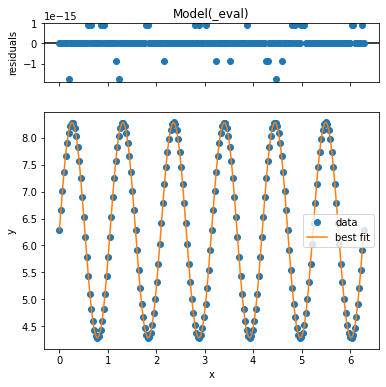

2.8398992587956425e-29
1.441573227815047e-31


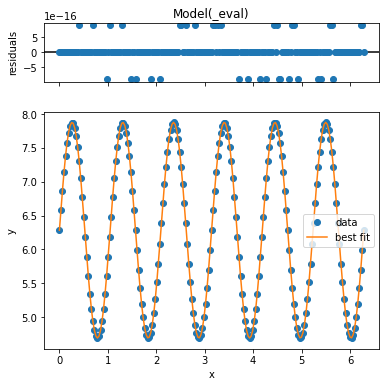

3.7076462545387555e-29
1.882053936314089e-31


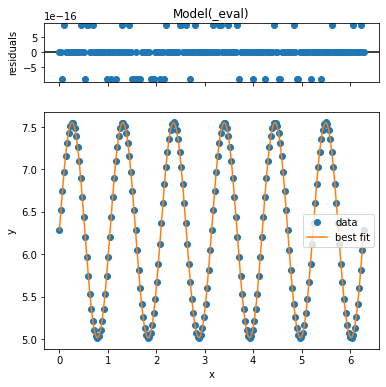

1.2041841811341152e-23
6.112610056518352e-26


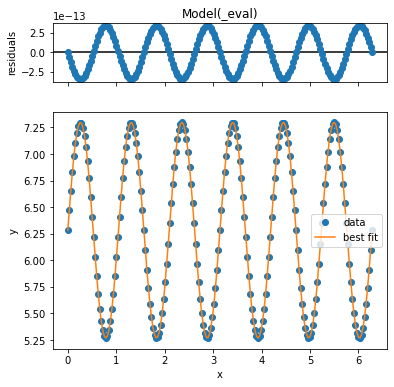

4.425509678289876e-28
2.246451613345115e-30


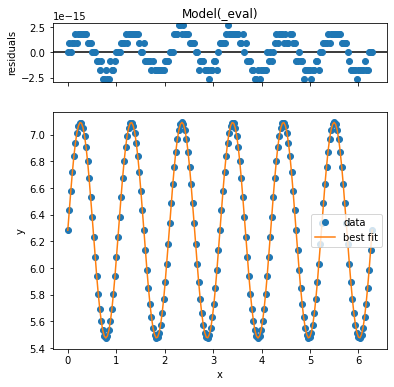

2.663194416026136e-27
1.351875338084333e-29


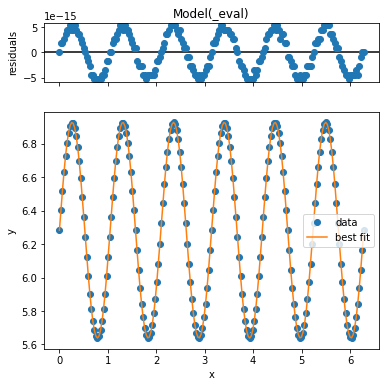

In [3]:
sineModel = lmfit.models.ExpressionModel("C + A*sin(n*x)*cos(n*t)")
params = sineModel.make_params(C=rad, A=rad, n=n, x=x, t = 0)

# check first 6 steps in time to see behavior over time
for i in range(6):
    sineResult = sineModel.fit(w[:, i], params, x=x)
    print(sineResult.chisqr)
    print(sineResult.redchi)
#     print(sineResult.fit_report())
    sineResult.plot()
    plt.show()

# sineResult.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
A    0.7194     -inf      inf 8.068e-09     True     None     None
C     6.283     -inf      inf 2.599e-16     True     None     None
n         6     -inf      inf 1.561e-16     True     None     None
t     3.065     -inf      inf 3.771e-09     True     None     None
2.663194416026136e-27
1.351875338084333e-29


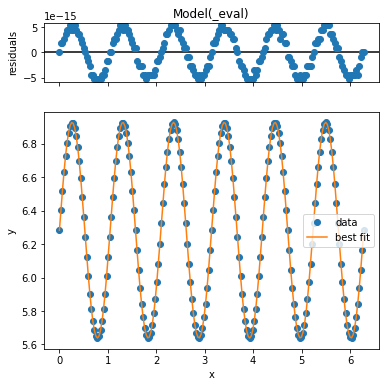

In [4]:
# plt.plot(x, sineResult.best_fit, label = f'sine fit, $\chi^2_r$ = {sineResult.redchi:.3f}')
sineResult.plot()
sineResult.fit_report()
sineResult.params.pretty_print()
print(sineResult.chisqr)
print(sineResult.redchi)

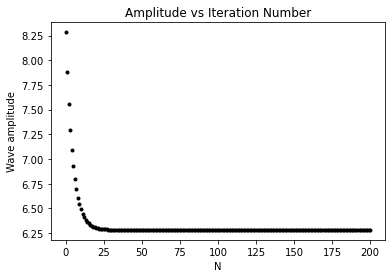

In [5]:
amps = [np.max(w[:, i] ) for i in range(N+1)] 


nvals = np.arange(0, N+1)

# decayModel = lmfit.models.PowerLawModel()
# decay_params = decayModel.make_params()
# decayResult = decayModel.fit(amps, decay_params, x=nvals)

# decayResult.plot()
# find the amplitude at every point in time

# Parameter names and starting values

plt.figure()
plt.title('Amplitude vs Iteration Number')
plt.plot(amps, 'k.')
plt.xlabel('N')
plt.ylabel('Wave amplitude')
plt.show()

(note that I attempted to fit this to a power law model to see if that would show the behavior but this proved to be more difficult than I thought)

### Plots/Results

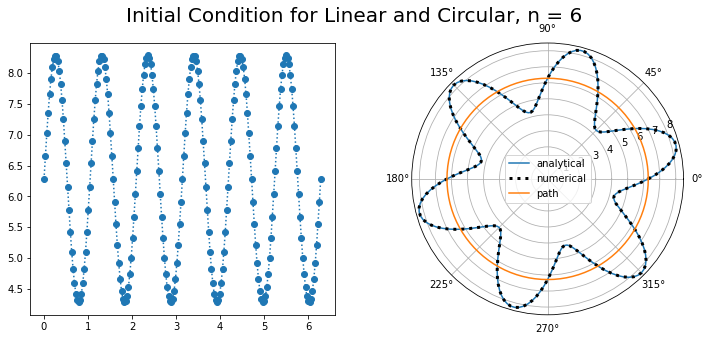

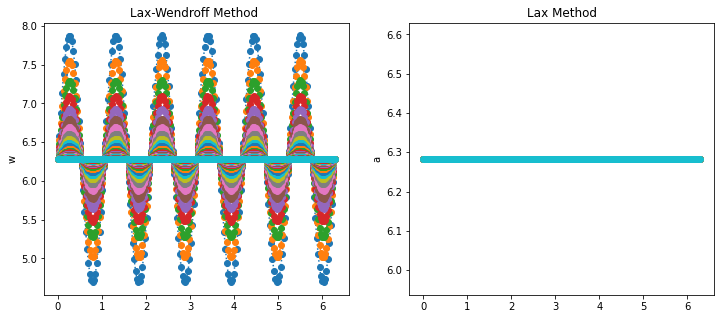

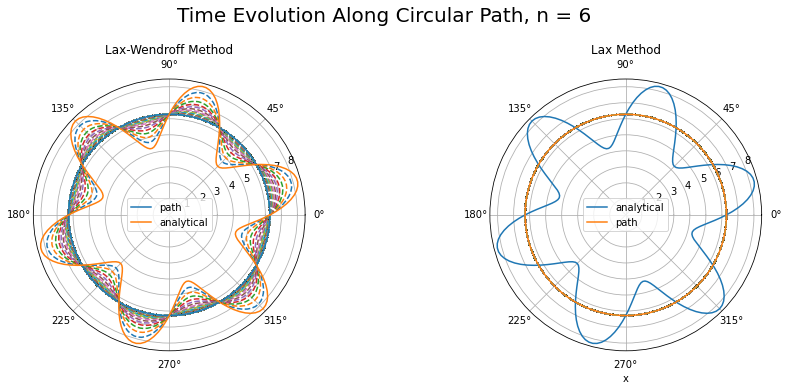

In [6]:
fig0 = plt.figure(figsize = (12, 5))
ax00 = plt.subplot(121)
ax01 = plt.subplot(122, projection = 'polar')
if initCond == 'stand' or 'opp_stand':
    ax01.plot(x, rad + 2*np.sin(n*x), label = 'analytical')
elif initCond == 'sine':
    ax01.plot(x, rad + np.sin(2*n*np.pi*x/L), label = 'analytical')
ax00.plot(x, w[:, 0], 'o:', label='Initial Condition')

# ax00.xlim([-0.1, max(x) + dx])
# fig1, ax1 = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': 'polar'}, figsize = (10, 8))

ax01.plot(x, w[:, 0], 'k:', label = 'numerical', linewidth = 3)
ax01.plot(x, rad * np.ones(len(x)), label = 'path')
ax01.grid(True)
ax01.legend()

plt.suptitle(f"Initial Condition for Linear and Circular, n = {n}", fontsize=20)

fig2, ax2 = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 5))
fig3, ax3 = plt.subplots(nrows=1, ncols = 2, subplot_kw={'projection': 'polar'}, figsize = (15, 5))

for j in range(1, time_steps + 1):
    ax2[0].plot(x, w[:, j], 'o:')
    ax2[1].plot(x, a[:, j], 'o:')
    ax3[0].plot(x, w[:, j], '--')
    ax3[1].plot(x, a[:, j], '--')
    
plt.xlabel('x')
ax2[0].set_ylabel('w')
ax2[0].set_title(f'Lax-Wendroff Method ')
ax2[1].set_ylabel('a')
ax2[1].set_title(f'Lax Method')
plt.suptitle(f'Time Evolution for Linear Path, n = {n}' , fontsize=20)

ax3[0].plot(x, rad * np.ones(len(x)), label = 'path')
ax3[0].set_title('Lax-Wendroff Method')

if initCond == 'stand' or 'opp_stand':
    ax3[0].plot(x, rad + 2*np.sin(n*x), label = 'analytical')
    ax3[1].plot(x, rad + 2*np.sin(n*x), label = 'analytical')
elif initCond == 'sine':
    ax3[0].plot(x, rad + np.sin(2*n*np.pi*x/L), label = 'analytical')
    ax3[1].plot(x, rad + np.sin(2*n*np.pi*x/L), label = 'analytical')

ax3[1].plot(x, rad * np.ones(len(x)), label = 'path')
ax3[0].legend()
ax3[1].legend()
ax3[1].set_title('Lax Method')
plt.suptitle(f'Time Evolution Along Circular Path, n = {n}', fontsize=20, y = 1.08)
plt.savefig(f'time_evol_n={n}.png')

plt.show()